In [1]:
using Pkg
pkg"activate .."

 Activating environment at `~/Research/SkewHierarchicalTest/Project.toml`


In [2]:
using Distributions
using LaTeXStrings
using LinearAlgebra
using ReverseDiff
using SkewHierarchicalTest
using StatsPlots
using Turing

In [3]:
Turing.setadbackend(:reversediff)

:reversediff

Here we construct a 2D Gaussian hierarchical model for two variables $x$ and $y$:
$$
\log x, \log y \sim N\left( \mathbf{\mu}, \mathbf{\Sigma} \right)
$$
with mean $\mathbf{\mu}$ and covariance $\mathbf{\Sigma}$.  

The measurement model gives a skew likelihood: we measure variables $w$ and $u$ defined by 
$$
\log w \sim N(\log x, 1)
$$
and
$$
\log u \sim N\left( \log x + \log y, 1 \right).
$$
The variable $u$ is a measurement of the product $xy$ with some considerable uncertainty.  Together the likelihood for $x$ and $y$ looks something like the contour below:

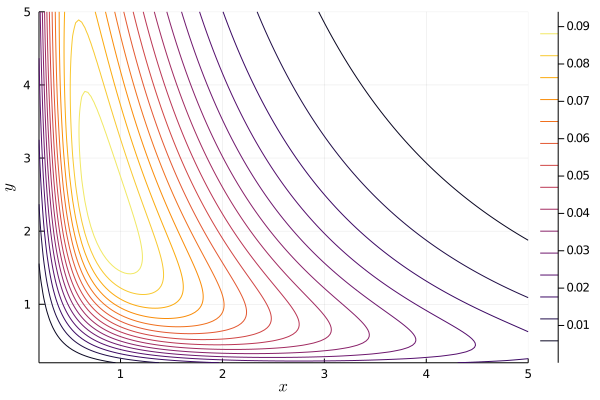

In [4]:
xt = 1.0
yt = 1.0

wobs = exp(log(xt) + randn())
uobs = exp(log(xt) + log(yt) + randn())

xs = 0.2:0.03:5.0
ys = 0.2:0.03:5.0

contour(xs, ys, [pdf(LogNormal(log(x)+log(y), 1.0), uobs)*pdf(LogNormal(log(x), 1.0), wobs) for y in ys, x in xs], xlabel=L"x", ylabel=L"y")

Here is the model:

In [5]:
@model function skew2d_model(w_obs, u_obs)
    N = length(w_obs)
    
    mu ~ MvNormal(2, 1.0)
    
    sigma ~ filldist(truncated(Normal(0,1), 0, Inf), 2) # The covariance scales are N(0,1)
    corr ~ LKJ(2, 2) # LKJ prior on correlation matrix (no scale); LKJ(dim, eta) is proportional to det(C)^{eta-1}, so eta = 2 *weakly* prefers identity
    
    L = Diagonal(sigma) * Matrix(cholesky(corr).L) # L is the Cholesky decomp of L*L^T = Sigma = diag(sigma)*corr*diag(sigma)
    
    log_xy_unit ~ filldist(MvNormal(2, 1.0), N)
    log_xy = [mu + L*log_xy_unit[:,i] for i in 1:N]
    xy = [exp.(log_xy[i]) for i in 1:N] # log(xy) ~ N(mu, Sigma)
    
    xs = [xy[i][1] for i in 1:N]
    ys = [xy[i][2] for i in 1:N]
    
    log_xs = [log_xy[i][1] for i in 1:N]
    log_ys = [log_xy[i][2] for i in 1:N]
    
    w_obs ~ arraydist([LogNormal(log_xs[i], 1.0) for i in 1:N])
    u_obs ~ arraydist([LogNormal(log_xs[i] + log_ys[i], 1.0) for i in 1:N])
    
    return (xy = xy, Sigma = Diagonal(sigma) * corr * Diagonal(sigma))
end

skew2d_model (generic function with 1 method)

Once again, we stress the model by fixing $x$ and $y$.

In [6]:
N = 1000
x = 1.0
y = 1.0

w_obs, u_obs = with_seed(1929671181010419190) do 
    w_obs = exp.(log.(x) .+ randn(N))
    u_obs = exp.(log.(x) .+ log.(y) .+ randn(N))
    (w_obs, u_obs)
end

model = skew2d_model(w_obs, u_obs)
trace = sample(model, NUTS(), 1000)

# Let's just show the summary stats for the relevant hyperparameters.
trace[[Symbol("mu[1]"), Symbol("mu[2]"), Symbol("sigma[1]"), Symbol("sigma[2]"), Symbol("corr[1,2]")]]

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/PyTy2/src/inference/hmc.jl:188
Sampling:  10%|████                                     |  ETA: 0:23:49┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/wfarr/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:09:20


Chains MCMC chain (1000×5×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = corr[1,2], mu[1], mu[2], sigma[1], sigma[2]
internals         = 

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

   corr[1,2]   -0.0987    0.4429     0.0140    0.0372   119.8398    1.0096
       mu[1]    0.0301    0.0314     0.0010    0.0015   558.7102    1.0002
       mu[2]   -0.0074    0.0435     0.0014    0.0019   670.6732    0.9991
    sigma[1]    0.0959    0.0625     0.0020    0.0060    94.1035    1.0350
    sigma[2]    0.1488    0.1003     0.0032    0.0136    63.9956    1.0030

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

   corr[1,2]   -0.8035   -0.4662   -0.1358    0.2186    0.7706
       mu[1]   -0.03

In [7]:
genq = generated_quantities(model, trace);

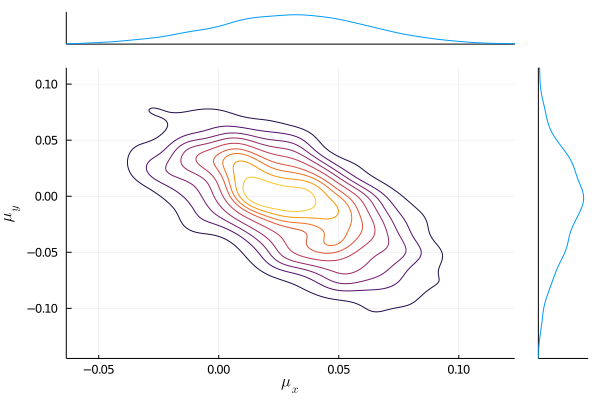

In [8]:
marginalkde(trace[Symbol("mu[1]")], trace[Symbol("mu[2]")], xlabel=L"\mu_x", ylabel=L"\mu_y")

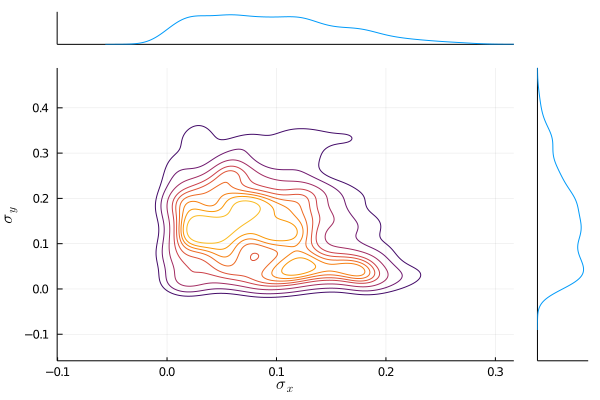

In [9]:
marginalkde(trace[Symbol("sigma[1]")], trace[Symbol("sigma[2]")], xlabel=L"\sigma_x", ylabel=L"\sigma_y")

Do we pick up on the skew, or is the correlation between $x$ and $y$ consistent with zero?  (Actually, we don't expect to ever constrain the correlation---since "truth" is just a single point, $(x,y) = (1,1)$, the population just contracts around that point, but it doesn't get any correlation out of the observations.  So all we can do is just test that we don't *spuriously* pick up on the correlations of the likelihood.)

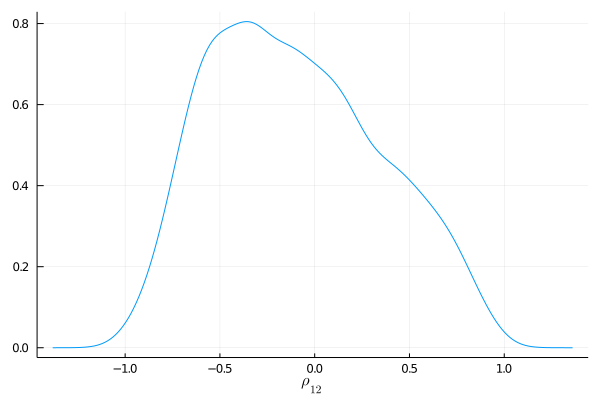

In [10]:
density(trace[Symbol("corr[1,2]")], xlabel=L"\rho_{12}", legend=nothing)

Here we plot the posterior $x$ and $y$ distribution on some random observation:

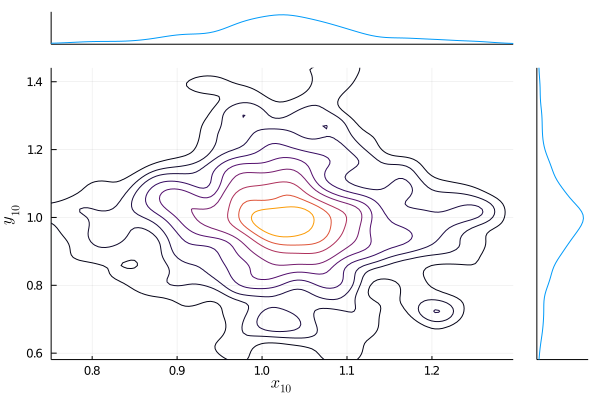

In [11]:
marginalkde([g.xy[10][1] for g in genq], [g.xy[10][2] for g in genq], xlabel=L"x_{10}", ylabel=L"y_{10}")